Original code taken from https://medium.com/@aungkyawmyint_26195/multi-layer-perceptron-mnist-pytorch-463f795b897a

New things:
* Used a binary transformer with thresholding
* added functionality for switching between different artchitecutres

Other
* replaced some magic numbers with config variables
* Added variable to switch between architectures

In [1]:
import torch
import numpy as np
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
from config import *

# Settings

In [2]:
from models.mnist_binary_conf import * # load configuration file for model

# Data Preparation

In [3]:
# choose the training and testing datasets
train_data = datasets.MNIST(root = 'data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = 'data', train = False, download = True, transform = transform)

assert TRAIN_SIZE >= 0  # Error: Invalid TRAIN_SIZE
assert TRAIN_SIZE <= len(train_data) # Error: Invalid TRAIN_SIZE

# obtain training indices that will be used for validation
if TRAIN_SIZE == 0:
    num_train = len(train_data)
else:
    num_train = TRAIN_SIZE

indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler, num_workers = num_workers)
test_loader =  torch.utils.data.DataLoader(test_data,  batch_size = batch_size, num_workers = num_workers)

# Visualize a batch of training data

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

ValueError: num must be 1 <= num <= 20, not 21

# Define Network Architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()    
        layers(self) # defined in the loaded conf file

    def forward(self, x):   
        return forward(self, x) # defined in loaded conf file

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=784, bias=True)
  (fc2): Linear(in_features=784, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=784, bias=True)
  (fc4): Linear(in_features=784, out_features=784, bias=True)
  (fc5): Linear(in_features=784, out_features=10, bias=True)
)


# Specify Loss function and Optimizer

In [6]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

# Train the network

In [7]:
# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity
for epoch in range(n_epochs):
    # monitor losses
    train_loss = 0
    valid_loss = 0
    
     
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data,label in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    for data,label in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)
    
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), model_file_name)
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.120730 	Validation Loss: 0.199700
Validation loss decreased (inf --> 0.199700).  Saving model ...
Epoch: 2 	Training Loss: 1.406887 	Validation Loss: 0.152053
Validation loss decreased (0.199700 --> 0.152053).  Saving model ...
Epoch: 3 	Training Loss: 1.026849 	Validation Loss: 0.139114
Validation loss decreased (0.152053 --> 0.139114).  Saving model ...
Epoch: 4 	Training Loss: 0.801923 	Validation Loss: 0.131282
Validation loss decreased (0.139114 --> 0.131282).  Saving model ...
Epoch: 5 	Training Loss: 0.655549 	Validation Loss: 0.136046


# Load the Model with Lowest Validation Loss

In [8]:
model.load_state_dict(torch.load(model_file_name))

<All keys matched successfully>

# Test the trained Network

In [9]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.325229

Test Accuracy of     0: 77% (756/980)
Test Accuracy of     1: 85% (974/1135)
Test Accuracy of     2: 51% (528/1032)
Test Accuracy of     3: 49% (496/1010)
Test Accuracy of     4: 60% (593/982)
Test Accuracy of     5: 36% (322/892)
Test Accuracy of     6: 61% (593/958)
Test Accuracy of     7: 77% (794/1028)
Test Accuracy of     8: 33% (329/974)
Test Accuracy of     9: 49% (499/1009)

Test Accuracy (Overall): 58% (5884/10000)


# Visualize Sample Test Results

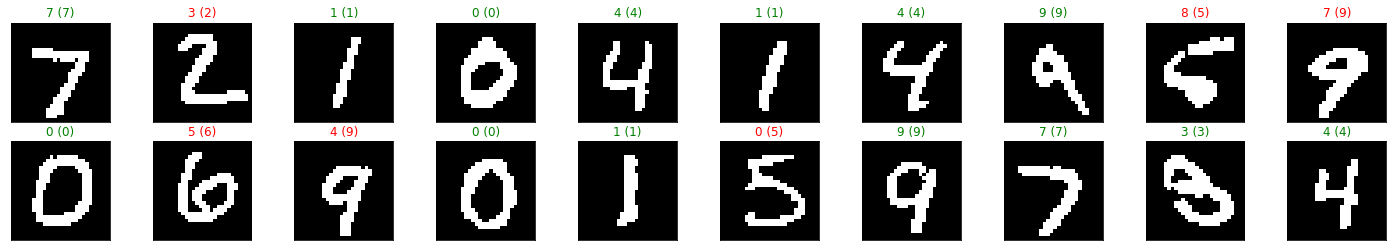

In [10]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()
# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))